<a href="https://colab.research.google.com/github/chiranjeevi-manike/Stock-Price-Prediction/blob/master/Stock_Price_Prediction_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stock Price Prediction Using LSTM**

In [1]:
!pip install yfinance

     |████████████████████████████████| 5.5MB 19.6MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=d864e02455cb9dac052098f53bd1f645a855bdc69e8a2d66c9cecd6493c38ce8
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
import yfinance as yf

In [14]:
data = yf.download('GOOGL', start = '2000-01-01', end = '2020-12-20', progress = True)

[*********************100%***********************]  1 of 1 completed


In [15]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659000
2004-08-20,50.555557,54.594593,50.300301,54.209209,54.209209,22834300
2004-08-23,55.430431,56.796795,54.579578,54.754753,54.754753,18256100
2004-08-24,55.675674,55.855854,51.836838,52.487488,52.487488,15247300
2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188600


In [16]:
data.to_csv('google.csv',index = True)

In [17]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM,Dense,Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mdates
from sklearn import linear_model

# **Reading data using parse date**

As it is timeseries data so we have to read the data by parsing date means making data column as index.



In [19]:
df_final = pd.read_csv("google.csv",na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)

In [20]:
df_final.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659000
2004-08-20,50.555557,54.594593,50.300301,54.209209,54.209209,22834300
2004-08-23,55.430431,56.796795,54.579578,54.754753,54.754753,18256100
2004-08-24,55.675674,55.855854,51.836838,52.487488,52.487488,15247300
2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188600


In [21]:
df_final.shape

(4114, 6)

In [22]:
df_final.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4114.000000,4114.000000,4114.000000,4114.000000,4114.000000,4.114000e+03
mean,553.424943,558.697349,547.870397,553.425008,553.425008,6.818360e+06
std,406.599503,410.604207,402.740464,406.859588,406.859588,7.855749e+06
min,49.644646,50.920921,48.028027,50.055054,50.055054,5.206000e+05
25%,242.129623,245.005005,239.907410,242.229736,242.229736,1.813400e+06
50%,351.333832,354.814819,348.228226,350.718231,350.718231,4.112600e+06
75%,807.395004,812.925018,803.699982,808.005005,808.005005,8.629000e+06
max,1820.540039,1843.829956,1817.000000,1824.969971,1824.969971,8.215110e+07


In [23]:
df_final.isnull().values.any()

False

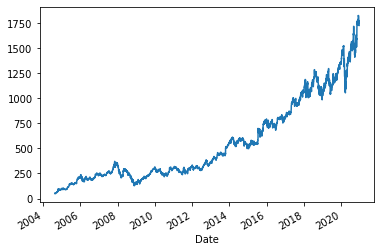

In [24]:
df_final['Adj Close'].plot()

# **Correlation Analysis**

In [25]:
X=df_final.drop(['Adj Close'],axis=1)
X=X.drop(['Close'],axis=1)

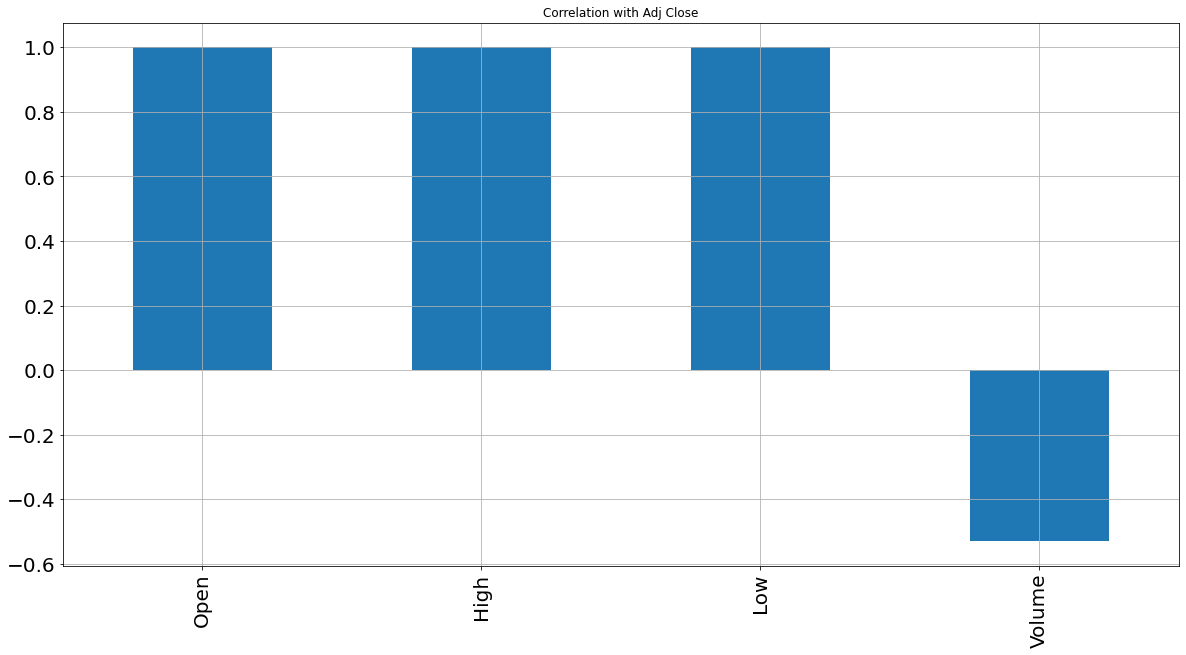

In [26]:
X.corrwith(df_final['Adj Close']).plot.bar(
        figsize = (20, 10), title = "Correlation with Adj Close", fontsize = 20,
        rot = 90, grid = True)

In [27]:
test = df_final
# Target column
target_adj_close = pd.DataFrame(test['Adj Close'])
display(test.head())

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659000
2004-08-20,50.555557,54.594593,50.300301,54.209209,54.209209,22834300
2004-08-23,55.430431,56.796795,54.579578,54.754753,54.754753,18256100
2004-08-24,55.675674,55.855854,51.836838,52.487488,52.487488,15247300
2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188600


In [28]:
# selecting Feature Columns
feature_columns = ['Open', 'High', 'Low', 'Volume']

# **Normalizing the data**

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_minmax_transform_data = scaler.fit_transform(test[feature_columns])
feature_minmax_transform = pd.DataFrame(columns=feature_columns, data=feature_minmax_transform_data, index=test.index)
feature_minmax_transform.head()

,Open,High,Low,Volume
Date,,,,
2004-08-19,0.000229,0.000648,0.000000,0.540710
2004-08-20,0.000514,0.002049,0.001285,0.273350
2004-08-23,0.003267,0.003277,0.003704,0.217266
2004-08-24,0.003406,0.002752,0.002153,0.180407
2004-08-25,0.001631,0.001748,0.002241,0.106186


In [30]:
display(feature_minmax_transform.head())
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', target_adj_close.shape)

# Shift target array because we want to predict the n + 1 day value


target_adj_close = target_adj_close.shift(-1)
validation_y = target_adj_close[-90:-1]
target_adj_close = target_adj_close[:-90]

# Taking last 90 rows of data to be validation set
validation_X = feature_minmax_transform[-90:-1]
feature_minmax_transform = feature_minmax_transform[:-90]
display(validation_X.tail())
display(validation_y.tail())

print("\n -----After process------ \n")
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', target_adj_close.shape)
display(target_adj_close.tail())

,Open,High,Low,Volume
Date,,,,
2004-08-19,0.000229,0.000648,0.000000,0.540710
2004-08-20,0.000514,0.002049,0.001285,0.273350
2004-08-23,0.003267,0.003277,0.003704,0.217266
2004-08-24,0.003406,0.002752,0.002153,0.180407
2004-08-25,0.001631,0.001748,0.002241,0.106186


Shape of features :  (4114, 4)
Shape of target :  (4114, 1)


,Open,High,Low,Volume
Date,,,,
2020-12-11,0.965814,0.962898,0.963674,0.005032
2020-12-14,0.971867,0.969865,0.961633,0.013866
2020-12-15,0.965735,0.955475,0.957416,0.006710
2020-12-16,0.970958,0.958325,0.961594,0.008737
2020-12-17,0.968033,0.956986,0.951469,0.014987


,Adj Close
Date,
2020-12-11,1752.260010
2020-12-14,1761.079956
2020-12-15,1757.189941
2020-12-16,1740.510010
2020-12-17,1726.219971



 -----After process------ 

Shape of features :  (4024, 4)
Shape of target :  (4024, 1)


,Adj Close
Date,
2020-08-06,1498.369995
2020-08-07,1496.819946
2020-08-10,1480.540039
2020-08-11,1507.239990
2020-08-12,1516.650024


# **Train test Split using Timeseriessplit**

In [31]:
ts_split= TimeSeriesSplit(n_splits=10)
for train_index, test_index in ts_split.split(feature_minmax_transform):
        X_train, X_test = feature_minmax_transform[:len(train_index)], feature_minmax_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = target_adj_close[:len(train_index)].values.ravel(), target_adj_close[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [32]:
X_train.shape

(3659, 4)

In [33]:
X_test.shape

(365, 4)

In [34]:
y_train.shape

(3659,)

In [35]:
y_test.shape

(365,)

In [36]:
def validate_result(model, model_name):
    predicted = model.predict(validation_X)
    RSME_score = np.sqrt(mean_squared_error(validation_y, predicted))
    print('RMSE: ', RSME_score)
    
    R2_score = r2_score(validation_y, predicted)
    print('R2 score: ', R2_score)

    plt.plot(validation_y.index, predicted,'r', label='Predict')
    plt.plot(validation_y.index, validation_y,'b', label='Actual')
    plt.ylabel('Price')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.title(model_name + ' Predict vs Actual')
    plt.legend(loc='upper right')
    plt.show()

# **Benchmark Model**

RMSE:  409.3529121252417
R2 score:  -10.223792779246958


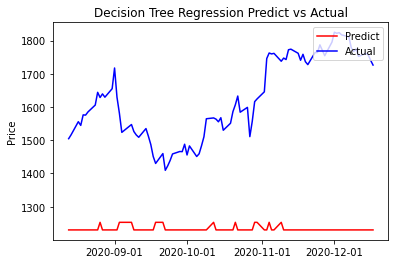

In [37]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=0)

benchmark_dt=dt.fit(X_train, y_train)

validate_result(benchmark_dt, 'Decision Tree Regression')

# **Process the data for LSTM**

In [38]:
X_train =np.array(X_train)
X_test =np.array(X_test)

X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# **Model building : LSTM**

In [39]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(1, X_train.shape[1]), activation='relu', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=200, batch_size=8, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/200
458/458 [==============================] - 2s 2ms/step - loss: 83705.8026
Epoch 2/200
458/458 [==============================] - 1s 2ms/step - loss: 80212.9972
Epoch 3/200
458/458 [==============================] - 1s 2ms/step - loss: 75328.7543
Epoch 4/200
458/458 [==============================] - 1s 2ms/step - loss: 69049.6207
Epoch 5/200
458/458 [==============================] - 1s 2ms/step - loss: 61958.7382
Epoch 6/200
458/458 [==============================] - 1s 2ms/step - loss: 54552.6396
Epoch 7/200
458/458 [==============================] - 1s 2ms/step - loss: 47223.0662
Epoch 8/200
458/458 [==============================] - 1s 2ms/step - loss: 40284.0997
Epoch 9/200
458/458 [==============================] - 1s 2ms/step - loss: 33988.7137
Epoch 10/200
458/458 [==============================] - 1s 2ms/step - loss: 28534.6775
Epoch 11/200
458/458 [==============================] - 1s 2ms/step - loss: 24062.8781
Epoch 12/200
458/458 [==============================

# **Evaluation of Model**

In [40]:
y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
r2_train = r2_score(y_train, y_train_pred_lstm)

print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)

The R2 score on the Train set is:	0.999
The R2 score on the Test set is:	0.938


# **Predictions made by LSTM**

In [41]:
score_lstm= model_lstm.evaluate(X_tst_t, y_test, batch_size=1)

365/365 [==============================] - 1s 862us/step - loss: 1088.0730


In [42]:
print('LSTM: %f'%score_lstm)

LSTM: 1088.072998


In [43]:
y_pred_test_LSTM = model_lstm.predict(X_tst_t)

# **LSTM's Prediction Visual**

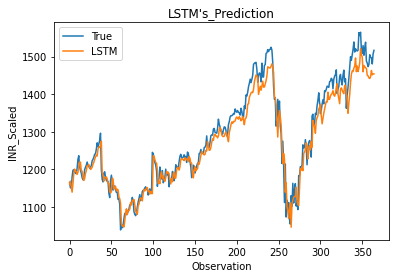

In [44]:

plt.plot(y_test, label='True')
plt.plot(y_pred_test_LSTM, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

# **Converting Prediction data**

In this step I have made the prediction of test data and will convert the dataframe to csv so that we can see the price difference between actual and predicted price.

In [45]:
col1 = pd.DataFrame(y_test, columns=['True'])

col2 = pd.DataFrame(y_pred_test_LSTM, columns=['LSTM_prediction'])

col3 = pd.DataFrame(history_model_lstm.history['loss'], columns=['Loss_LSTM'])
results = pd.concat([col1, col2, col3], axis=1)
results.to_excel('PredictionResults_LSTM_NonShift.xlsx')

# **Conclusion**

It is impossible to get a model that can 99% predict the price without any error, there are too many factors can affect the stock prices. So, we cannot hope there is a perfect model, but the general trend of predicted price is in line with the actual data, so the trader could have an indicator to reference, and makes trading decision by himself.

Further, we can improve the model's accuracy by increasing the epochs, trying out different activation functions or even change the model's structure. As exact